In [ ]:
import os
import re
from matplotlib import pyplot as plt
import tensorflow as tf                                                         # load tensorflow
import tensorflow_datasets as tfds                                              # tensorflow datasets
import pandas as pd

In [ ]:
tfds.disable_progress_bar()
train,valid,test=tfds.load('rock_paper_scissors',split=['train','test[:50%]','test[:50%]'],shuffle_files=True,batch_size=128,
                           as_supervised=True)
print('Total training images:',train.cardinality()*128)
print('Total validation images:',valid.cardinality()*128)
print('Total testing images:',test.cardinality()*128)

Total training images: tf.Tensor(2560, shape=(), dtype=int64)
Total validation images: tf.Tensor(256, shape=(), dtype=int64)
Total testing images: tf.Tensor(256, shape=(), dtype=int64)


In [ ]:
training_classes=['rock','paper','scissors']

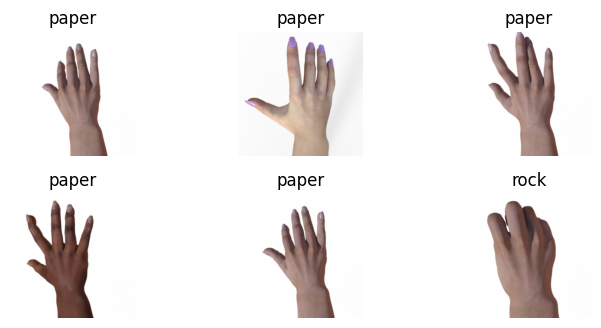

In [ ]:
# make plot data training data
for images,labels in train.take(1):break                                        # get a batch of data
images_to_plot:int=6                                                            # number of images to plot
plt.figure(figsize=(7,5))                                                       # figure size
for index in range(images_to_plot):                                             # loop over image index
  plt.subplot(3,3,index+1)                                                      # subplot rows = 3, columns = 3
  plt.imshow(images[index].numpy().astype('uint8'))                             # make plot image
  plt.axis('off')                                                               # make axis off
  plt.title(training_classes[labels[index].numpy()])                            # make add labels as class names
plt.tight_layout()                                                              # adjust layout space
plt.show()                                                                      # make plot show

In [ ]:
base_model=tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(192,192,3),alpha=1.0,include_top=False,
                                               weights='imagenet',input_tensor=None,pooling=None,classes=1000,
                                               classifier_activation='softmax')

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
inputs=tf.keras.layers.Input(shape=(192,192,3),batch_size=None,name='model_inputs')# add input layer
model_x=tf.keras.layers.Rescaling(1/255,offset=0.0,name='rescaler')(inputs)     # rescale inputs
model_x=base_model(model_x)                                                     # feed inputs to base model
model_x=tf.keras.layers.Flatten(name='flatten')(model_x)                         # make flatten outputs
model_x=tf.keras.layers.Dense(1024,activation='relu')(model_x)                  # apply dense layer
outputs=tf.keras.layers.Dense(len(training_classes),activation='softmax')(model_x)# output layer
model=tf.keras.Model(inputs=[inputs],outputs=[outputs],name='custom_mobilenetv2')     # build model
model.summary(line_length=120,positions=None,print_fn=None,expand_nested=True,show_trainable=True,layer_range=None)# print model summary

Model: "custom_mobilenetv2"
___________________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           Trainable  
 model_inputs (InputLayer)                            [(None, 192, 192, 3)]                           0                 Y          
                                                                                                                                   
 rescaler (Rescaling)                                 (None, 192, 192, 3)                             0                 Y          
                                                                                                                                   
 mobilenetv2_1.00_192 (Functional)                    (None, 6, 6, 1280)                              2257984           Y          
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

In [ ]:
print('Maximum pixel values:',tf.reduce_max(images))                            # maximum pixel values in inputs
print('Minimum pixel values:',tf.reduce_min(images))                            # minimum pixel values in inputs
print('Object type of inputs (X):',type(images))                                # input types
print('Data type in inputs (X):',images.dtype)                                  # data type in inputs
print('Object type of outputs (y):',type(labels))                               # output types
print('Data type in outputs (X):',labels.dtype)                                 # data type in outputs

Maximum pixel values: tf.Tensor(255, shape=(), dtype=uint8)
Minimum pixel values: tf.Tensor(4, shape=(), dtype=uint8)
Object type of inputs (X): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in inputs (X): <dtype: 'uint8'>
Object type of outputs (y): <class 'tensorflow.python.framework.ops.EagerTensor'>
Data type in outputs (X): <dtype: 'int64'>


In [ ]:
random_flip=tf.keras.layers.RandomFlip('horizontal_and_vertical',name='random_flip')                      # random flip layer
random_zoom=tf.keras.layers.RandomZoom(height_factor=0.1,width_factor=0.1,name='random_zoom')             # random zoom layer
random_rotate=tf.keras.layers.RandomRotation(0.3,name='random_rotate')                                    # random rotate layers
random_brightness=tf.keras.layers.RandomBrightness(0.3,value_range=(0.0,255.0),name='random_brightness')  # random brightness layer
augmentations=[random_flip,random_zoom,random_rotate,random_brightness]                                   # make list of data augmentation
resizer=tf.keras.layers.Resizing(192,192,interpolation='nearest',name='rescaler')
# make apply augmentation on training data
for augmentation in augmentations:
  train.map(lambda images,labels: (augmentation(images),labels))                                           # make apply augmentation
train=train.map(lambda images,labels: (resizer(images),labels))
valid=valid.map(lambda images,labels: (resizer(images),labels))
test=test.map(lambda images,labels: (resizer(images),labels))

In [ ]:
# make compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# make early stopping
early_stop=tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy',min_delta=0,patience=10,verbose=1,mode='auto',restore_best_weights=True)

# make train model
history=model.fit(train,batch_size=128,epochs=10_000,verbose=2,callbacks=[early_stop],validation_split=0,validation_data=valid,
                  shuffle=True)

Epoch 1/10000
20/20 - 55s - loss: 6.5538 - sparse_categorical_accuracy: 0.8631 - val_loss: 170.0604 - val_sparse_categorical_accuracy: 0.6720 - 55s/epoch - 3s/step
Epoch 2/10000
20/20 - 18s - loss: 0.0034 - sparse_categorical_accuracy: 0.9992 - val_loss: 151.6623 - val_sparse_categorical_accuracy: 0.5914 - 18s/epoch - 921ms/step
Epoch 3/10000
20/20 - 19s - loss: 1.1654e-04 - sparse_categorical_accuracy: 1.0000 - val_loss: 130.9673 - val_sparse_categorical_accuracy: 0.5753 - 19s/epoch - 971ms/step
Epoch 4/10000
20/20 - 18s - loss: 2.9372e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 114.9607 - val_sparse_categorical_accuracy: 0.5430 - 18s/epoch - 892ms/step
Epoch 5/10000
20/20 - 21s - loss: 1.3649e-05 - sparse_categorical_accuracy: 1.0000 - val_loss: 101.7368 - val_sparse_categorical_accuracy: 0.5215 - 21s/epoch - 1s/step
Epoch 6/10000
20/20 - 18s - loss: 8.6225e-06 - sparse_categorical_accuracy: 1.0000 - val_loss: 90.0767 - val_sparse_categorical_accuracy: 0.5215 - 18s/epoch - 

In [ ]:
# see model history (first five epoches)
pd.DataFrame(history.history).head()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,6.553771,0.863095,170.060440,0.672043
1,0.003444,0.999206,151.662292,0.591398
2,0.000117,1.000000,130.967285,0.575269
3,0.000029,1.000000,114.960724,0.543011
4,0.000014,1.000000,101.736832,0.521505


In [ ]:
# see model history (last five epoches)
pd.DataFrame(history.history).tail()

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
6,0.000006,1.0,79.828926,0.526882
7,0.000005,1.0,70.752518,0.526882
8,0.000004,1.0,62.788033,0.532258
9,0.000003,1.0,55.675220,0.543011
10,0.000003,1.0,49.364639,0.553763


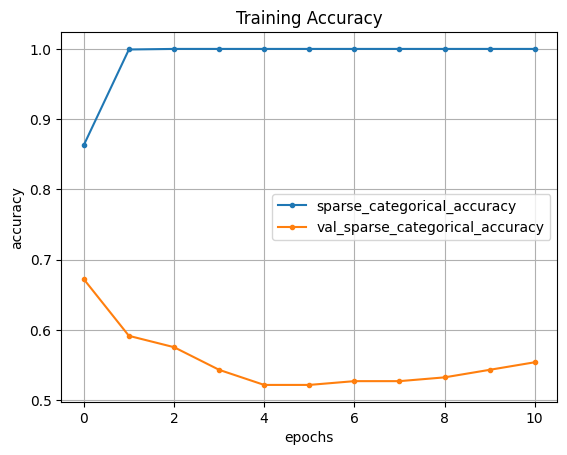

In [ ]:
# make plot training accuracy and validation accuracy
pd.DataFrame(history.history)[['sparse_categorical_accuracy','val_sparse_categorical_accuracy']].plot(marker='.')        # make plot
plt.grid(),plt.title('Training Accuracy'),plt.xlabel('epochs'),plt.ylabel('accuracy')                                    # add grid, title and axis labels
plt.show()                                                                                                               # make plot show

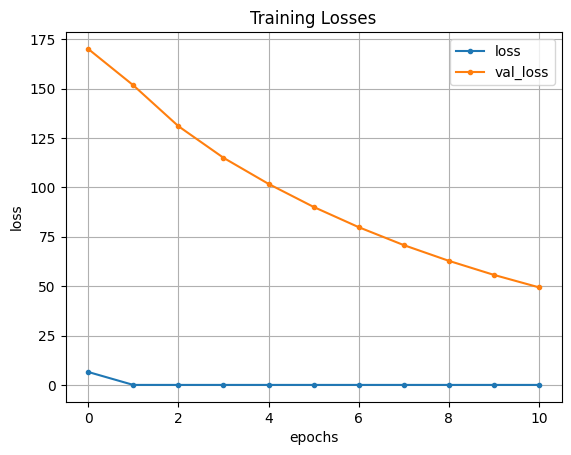

In [ ]:
# make plot training losses and validation losses
pd.DataFrame(history.history)[['loss','val_loss']].plot(marker='.')             # make plot
plt.grid(),plt.title('Training Losses'),plt.xlabel('epochs'),plt.ylabel('loss') # add grid, title and axis labels
plt.show()                                                                      # make plot show

In [ ]:
# evaluate model
results=model.evaluate(test,batch_size=None,verbose="auto",sample_weight=None,return_dict=True)
print('Testing results:',results)                                               # make print results

2/2 [==============================] - 2s 80ms/step - loss: 170.0604 - sparse_categorical_accuracy: 0.6720
Testing results: {'loss': 170.06044006347656, 'sparse_categorical_accuracy': 0.6720430254936218}


In [ ]:
# make save model (weights and configuration)
model.save('rps',overwrite=True,save_format=None)               # make save

In [20]:
!zip -r -qq "rps.zip" "rps"                                                     # make zip model
# make auto download model weights
from google.colab import files                                                  # load file class
files.download('rps.zip')                                                       # download model zip file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>